## Set up dataframe with features and labels

In [14]:
import sys
sys.path.append('/Users/q616967/Library/Python/3.10/lib/python/site-packages')

In [59]:
import os
import pandas as pd
import json
import numpy as np

from sklearn.model_selection import train_test_split

In [20]:
PROJECT_DIR = "/Users/q616967/Workspace/thesis/uni/xai-thesis/"
FEATURES_DIR = os.path.join(PROJECT_DIR, "feature_extraction/featureExtraction/output/")
RESPONSES_DIR = os.path.join(PROJECT_DIR, "responses/")

In [21]:
features_df = pd.read_csv(os.path.join(FEATURES_DIR, "merged_features.csv"))

In [22]:
responses_filename = "formatted_turbo14081857_turbo1508_eval.json"

with open(os.path.join(RESPONSES_DIR, responses_filename), "r") as f:
    responses = json.load(f)

In [44]:
idx_outcome_dict = {int(idx):res_dict['outcome'] for idx, res_dict in responses.items()}

labels_df = pd.DataFrame.from_dict(idx_outcome_dict, columns=['outcome'], orient='index')

try:
    assert len(features_df) == len(labels_df)
except AssertionError:
    print("Length mismatch between features and labels")

data_df = pd.merge(features_df, labels_df, left_index=True, right_index=True)

## Explore df

- currently using all the extracted features (2150)
- general rule: 10x more instances than features

In [45]:
data_df

,nwords,Admiration/Awe_GALC,Amusement_GALC,Anger_GALC,Anxiety_GALC,Beingtouched_GALC,Boredom_GALC,Compassion_GALC,Contempt_GALC,Contentment_GALC,...,mtld_ma_bi_aw,mtld_ma_wrap_aw,flesch,gunningFog,characters_per_word,syll_per_word,ttr,long_words,complex_words,outcome
0,127,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,18.024904,19.158333,94.041438,6.995000,4.039062,1.179688,0.375000,0.088608,0.037975,True
1,67,0.0,0.029851,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,29.302703,29.030769,78.717332,12.670149,4.134328,1.313433,0.671642,0.189189,0.135135,False
2,86,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,40.192308,47.289157,60.509558,13.391628,4.755814,1.523256,0.686047,0.212121,0.141414,True
3,70,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,36.098026,37.391304,64.467619,8.666667,4.771429,1.542857,0.671429,0.209877,0.086420,True
4,151,0.0,0.026490,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,52.615432,57.699301,80.805507,10.040301,4.407643,1.318471,0.592357,0.196721,0.092896,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,130,0.0,0.000000,0.007692,0.000000,0.0,0.007692,0.0,0.0,0.0,...,40.227782,40.791304,70.709583,9.240741,4.651852,1.474074,0.607407,0.214724,0.098160,False
696,66,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,33.316565,40.208955,59.160697,17.888557,4.985075,1.477612,0.641791,0.262500,0.187500,True
697,54,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,32.704545,38.320000,83.598333,9.422222,4.296296,1.240741,0.740741,0.161290,0.048387,True
698,85,0.0,0.035294,0.000000,0.011765,0.0,0.000000,0.0,0.0,0.0,...,39.381395,56.320988,73.904545,10.028571,4.750000,1.420455,0.704545,0.226415,0.103774,False


In [46]:
# drop columns with all NaNs
data_df.dropna(axis=1, how='all', inplace=True)
data_df.columns

Index(['nwords', 'Admiration/Awe_GALC', 'Amusement_GALC', 'Anger_GALC',
       'Anxiety_GALC', 'Beingtouched_GALC', 'Boredom_GALC', 'Compassion_GALC',
       'Contempt_GALC', 'Contentment_GALC',
       ...
       'mtld_ma_bi_aw', 'mtld_ma_wrap_aw', 'flesch', 'gunningFog',
       'characters_per_word', 'syll_per_word', 'ttr', 'long_words',
       'complex_words', 'outcome'],
      dtype='object', length=2150)

In [47]:
# drop all constant features
data_df = data_df.loc[:, (data_df != data_df.iloc[0]).any()]
data_df.columns

Index(['nwords', 'Admiration/Awe_GALC', 'Amusement_GALC', 'Anger_GALC',
       'Anxiety_GALC', 'Beingtouched_GALC', 'Boredom_GALC', 'Compassion_GALC',
       'Contempt_GALC', 'Contentment_GALC',
       ...
       'mtld_ma_bi_aw', 'mtld_ma_wrap_aw', 'flesch', 'gunningFog',
       'characters_per_word', 'syll_per_word', 'ttr', 'long_words',
       'complex_words', 'outcome'],
      dtype='object', length=2150)

In [48]:
# find columns with catergorical values, should be none
data_df.select_dtypes(include=['object']).columns

Index([], dtype='object')

In [49]:
# see if any columns has a non-numerical value
data_df.select_dtypes(exclude=['int64', 'float64']).columns

Index(['outcome'], dtype='object')

In [100]:
# split into train and test
train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=42)

X_train = train_df.drop(columns=['outcome'])
y_train = train_df['outcome']

X_test = test_df.drop(columns=['outcome'])
y_test = test_df['outcome']

## Select features (using sklearn)

In [101]:
# standardise the values of the features (to the same range/scale)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

For some features, almost all the values are zeros (or constant). I removed all the features with constant value from data_df (before the split), but after the split there can be features in X_train that have constant values.

- it throws a warning
- do another step of filtering
- same idx removed from train will have to be removed from test as well


In [102]:
# remove from array all columns that have constant values
#X_train = X_train[:, ~np.all(X_train[1:] == X_train[:-1], axis=0)]
#X_train.shape

# find indices of columns in array that have constant values
# (so that later I can remove by idx)
constant_idx = np.where(np.all(X_train[1:] == X_train[:-1], axis=0))[0]
constant_idx

array([  10,  256,  520,  864,  916,  957,  961,  962, 1043, 1176, 1225,
       1227, 1268, 1335, 1671, 1763, 1767, 1768, 1845, 1978, 2023, 2025,
       2066])

In [103]:
# !! removing by idx so do not run multiple times as the idx will change
# remove from array all columns that have idx in constant_idx
X_train = np.delete(X_train, constant_idx, axis=1)
X_train.shape

(560, 2126)

In [104]:
# remove constant idx columns from X_test as well
X_test = np.delete(X_test, constant_idx, axis=1)
X_test.shape


(140, 2126)

In [105]:
# try feature selection with sklearn
# select k features to keep (based on statistical tests)
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

selector = SelectKBest(f_classif, k=70)

# new arrays with only the selected features
X_train_fs = selector.fit_transform(X_train, y_train)
X_test_fs = selector.transform(X_test)

In [107]:
X_train_fs.shape

(560, 70)

In [108]:
# names of features that were selected
selected_idx = selector.get_support(indices=True)
data_df.columns[selected_idx]

Index(['Amusement_GALC', 'Longing_GALC', 'Weak_GI', 'Coll_GI', 'Ritual_GI',
       'Know_GI', 'Solve_GI', 'Time_GI', 'You_GI', 'Affgain_Lasswell',
       'Enltot_Lasswell', 'Skloth_Lasswell', 'Ptlw_Lasswell',
       'Anomie_Lasswell', 'Admiration/Awe_GALC_neg_3', 'Joy_GALC_neg_3',
       'Power_GI_neg_3', 'Work_GI_neg_3', 'Time_2_GI_neg_3', 'Our_GI_neg_3',
       'Rsptot_Lasswell_neg_3', 'Enloth_Lasswell_neg_3',
       'Arenalw_Lasswell_neg_3', 'Nation_Lasswell_neg_3',
       'Admiration/Awe_GALC_nouns', 'Longing_GALC_nouns', 'Dominance_nouns',
       'attention_nouns', 'Feel_GI_nouns', 'Fall_GI_nouns', 'Sv_GI_nouns',
       'Rspoth_Lasswell_nouns', 'Negaff_Lasswell_nouns',
       'Timespc_Lasswell_nouns', 'Relief_GALC_verbs', 'Strong_GI_verbs',
       'Relig_GI_verbs', 'Afftot_Lasswell_verbs', 'Enlloss_Lasswell_verbs',
       'Name_GI_adjectives', 'Powdoct_Lasswell_adjectives',
       'Trust_EmoLex_adverbs', 'Finish_GI_adverbs', 'Travel_GI_adverbs',
       'Eval_2_GI_adverbs', 'Abs_2_

In [132]:
# new dfs with only the selected features
data_df_fs = data_df.iloc[:, selected_idx]

# add the outcome column!
data_df_fs = data_df_fs.join(data_df['outcome'])

# transform boolean values to 0/1 in outcome column
data_df_fs['outcome'] = data_df_fs['outcome'].astype(int)

data_df_fs.head()

,Amusement_GALC,Longing_GALC,Weak_GI,Coll_GI,Ritual_GI,Know_GI,Solve_GI,Time_GI,You_GI,Affgain_Lasswell,...,Need_GI_adjectives_neg_3,Ord_GI_adjectives_neg_3,Ipadj_GI_adjectives_neg_3,Tension/Stress_GALC_adverbs_neg_3,Comform_GI_adverbs_neg_3,Com_GI_adverbs_neg_3,Natrpro_GI_adverbs_neg_3,Powtot_Lasswell_adverbs_neg_3,Wlbpsyc_Lasswell_adverbs_neg_3,outcome
0,0.000000,0.0,0.000000,0.000000,0.000000,0.007874,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.029851,0.0,0.029851,0.044776,0.074627,0.014925,0.044776,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.000000,0.0,0.046512,0.034884,0.023256,0.058140,0.046512,0.011628,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.000000,0.0,0.057143,0.000000,0.000000,0.028571,0.028571,0.000000,0.057143,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.026490,0.0,0.046358,0.006623,0.013245,0.033113,0.019868,0.006623,0.000000,0.006623,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


### Correlation (Pearson)

- remove features that are highly correlated to each other (keep the one that has higher correlation to the target variable)

In [166]:
def remove_collinear_features(features_df, threshold, target_name='outcome'):
    '''
    Check for collinear features (highly correlated to another feature)
    and remove the one with lower correlation to the target.

    Inputs:
        features_df: dataframe with features, which includes the target
        threshold: correlation threshold above which to remove features
        target_name: name of the target column
    
    Returns a df which excludes the collinear features.
    '''

    corr_matrix = features_df.corr()
    to_drop = []

    # Iterate through the correlation matrix and compare correlations
    for i in range(len(corr_matrix.columns) - 1):
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                feature1 = col.values[0]
                feature2 = row.values[0]

                if feature1 in to_drop or feature2 in to_drop:
                    continue
                
                correlation = round(val[0][0], 2)

                print(f"{feature1} | {feature2} | {correlation}\n",
                    "-> Removing the feature with lower correlation to target:")


                # Calculate correlations with outcome for both features
                corr_f1_y = features_df[feature1].corr(features_df[target_name])
                corr_f2_y = features_df[feature2].corr(features_df[target_name])

                # Drop the feature with lower correlation to outcome
                if corr_f1_y <= corr_f2_y:
                    to_drop.append(feature1)
                    print(f"\t{feature1}")
                else:
                    to_drop.append(feature2)
                    print(f"\t{feature2}")
                
    features_df = features_df.drop(columns=to_drop)

    return features_df

In [167]:
filtered_df = remove_collinear_features(data_df_fs, 0.5)
len(filtered_df.columns)

Ritual_GI | Amusement_GALC | 0.52
 -> Removing the feature with lower correlation to target:
	Amusement_GALC
Time_2_GI_neg_3 | Time_GI | 0.57
 -> Removing the feature with lower correlation to target:
	Time_GI
Enloth_Lasswell_neg_3 | Enltot_Lasswell | 0.9
 -> Removing the feature with lower correlation to target:
	Enloth_Lasswell_neg_3
Admiration/Awe_GALC_nouns | Admiration/Awe_GALC_neg_3 | 0.74
 -> Removing the feature with lower correlation to target:
	Admiration/Awe_GALC_neg_3
Afftot_Lasswell_verbs | Affgain_Lasswell | 0.83
 -> Removing the feature with lower correlation to target:
	Affgain_Lasswell
Skloth_Lasswell_adverbs | Wlbpsyc_Lasswell_adverbs | 1.0
 -> Removing the feature with lower correlation to target:
	Skloth_Lasswell_adverbs
Negative_EmoLex_nouns_neg_3 | Fear_EmoLex_nouns_neg_3 | 0.68
 -> Removing the feature with lower correlation to target:
	Negative_EmoLex_nouns_neg_3
Com_GI_adverbs_neg_3 | Comform_GI_adverbs_neg_3 | 1.0
 -> Removing the feature with lower correlatio

62

In [133]:
corr_df = data_df_fs.corr()

<Axes: >

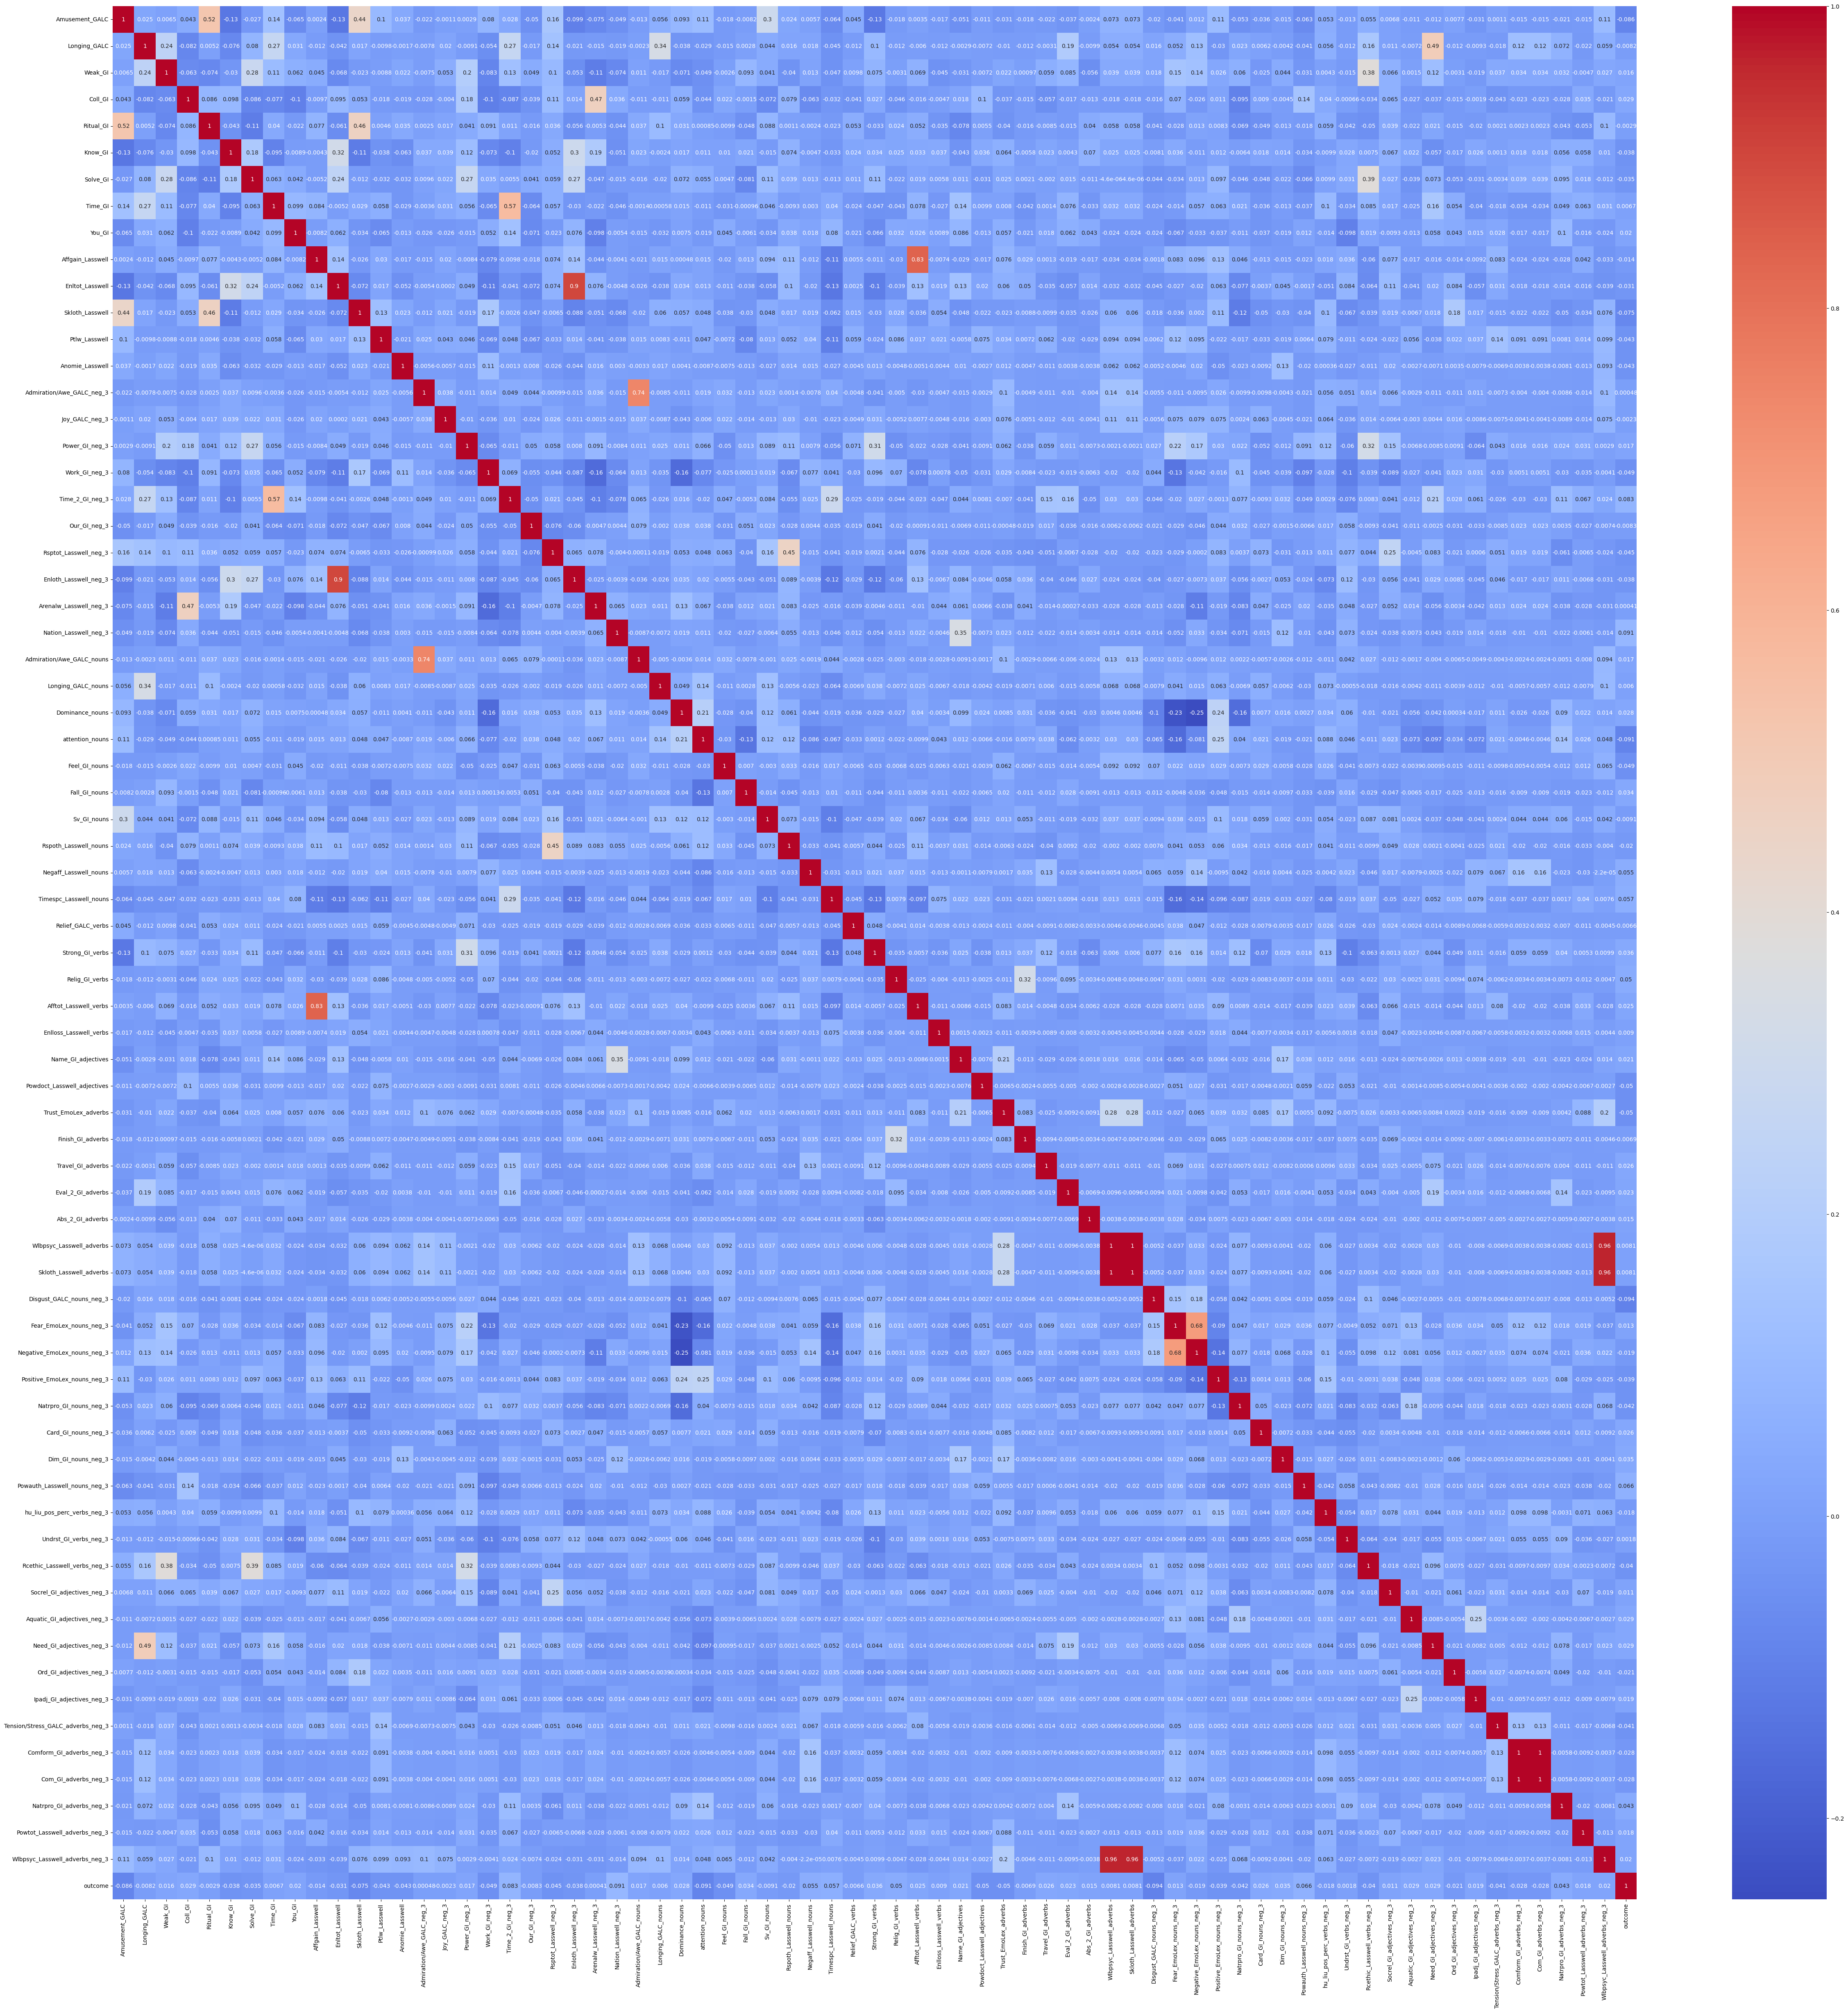

In [134]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(60,60))
sns.heatmap(corr_df, annot=True, cmap='coolwarm')